In [1]:
# load all units for movie/shuffled stationary and for spontaneous stationary
# take activity averages across time and compare unit activity
# filter units based on activity
# create report similar to sfn_panel3

# Unit Activity Report

In [2]:
%load_ext autoreload
%autoreload 2

In [13]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neo
from tqdm import tqdm
import os

# custom
import sys
sys.path.append("../../")
from allen_vc.plots import sync_plot
from allen_vc.stats import run_hierarchical_bootstrap

print("Packages Imported!")

Packages Imported!


In [35]:
# plot settings
plt.style.use(f'../../stylelib/sfn_2023.mplstyle')

### Load units

In [4]:
PROJECT_PATH = "G:/Shared drives/visual_encoding"

In [5]:
dir_results = f"{PROJECT_PATH}/data/blocks/segmented"

In [6]:
# for each session
    # load spont_stationary block, get first segment
    # for each unit
        # for each segment in spont_stationary
            # mean firing rate and std
            
        # for each segment in spont_running
            # mean firing rate
            
        # for each segment in movie
            # 
            
        # for each segment in shuffled
            # mean firing rate
            
        # if stim <= spont_stationary - spont_std or stim >= spont_stationary + spont std
            # provide print statement
            # delete unit from shuffled and stim blocks
            
        # if spont_running <= spont_stationary - spont_std or spont_running >= spont_stationary + spont std
            # provide print statement
            # delete unit from shuffled and stim blocks
            
        # add stim firing rate and run firing rate z-scores to array

# save out filtered block
# plot z-score dist

In [10]:
dir_spontaneous_stationary = f"{PROJECT_PATH}/data/blocks/segmented/spontaneous_stationary"
dir_spontaneous_running = f"{PROJECT_PATH}/data/blocks/segmented/spontaneous_running"
dir_movie = f"{PROJECT_PATH}/data/blocks/segmented/natural_movie_one_more_repeats"
dir_shuffled = f"{PROJECT_PATH}/data/blocks/segmented/natural_movie_one_shuffled"

for file in tqdm(os.listdir(dir_movie)):
    
    if file.split('.')[-1]!='mat':
        continue
    
    stationary_block = neo.io.NeoMatlabIO(filename=f"{dir_spontaneous_stationary}/{file}").read_block()
    running_block = neo.io.NeoMatlabIO(filename=f"{dir_spontaneous_running}/{file}").read_block()
    movie_block = neo.io.NeoMatlabIO(filename=f"{dir_movie}/{file}").read_block()
    shuff_block = neo.io.NeoMatlabIO(filename=f"{dir_shuffled}/{file}").read_block()
    session_id = file.split('_')[1].split('.')[0]
    
    print(f"STARTING SESSION: {session_id}")
    
    if len(stationary_block.segments)==0:
        print("No stationary spontaneous segments for comparison!")
        continue
    
    movie_block.segments = np.array(movie_block.segments)[~movie_block.annotations['running']]
    shuff_block.segments = np.array(shuff_block.segments)[~shuff_block.annotations['running']]
    
    total_units = 0
    stim_dropped_units = 0
    spont_dropped_units = 0
    
    running_Zs = []
    stim_Zs = []
    
    for i_train, spiketrain in enumerate(stationary_block.segments[0].spiketrains):
        
        unit_id = spiketrain.annotations['unit_id']
        
        stationary_rates = []
        running_rates = []
        stim_rates = []
        
        for segment in stationary_block.segments:
            
            spikes = segment.spiketrains[i_train-spont_dropped_units]
            assert spikes.annotations['unit_id'] == unit_id, f"Unit {unit_id} not aligned in stationary"
            
            stationary_rates.append(len(spikes)/spikes.duration.magnitude)
            
        for segment in running_block.segments:
            
            spikes = segment.spiketrains[i_train-spont_dropped_units]
            assert spikes.annotations['unit_id'] == unit_id, f"Unit {unit_id} not aligned in running"
            
            running_rates.append(len(spikes)/spikes.duration.magnitude)
            
        for segment in movie_block.segments:
            
            spikes = segment.spiketrains[i_train-stim_dropped_units]
            assert spikes.annotations['unit_id'] == unit_id, f"Unit {unit_id} not aligned in movie"
            
            stim_rates.append(len(spikes)/spikes.duration.magnitude)
            
        for segment in shuff_block.segments:
            
            spikes = segment.spiketrains[i_train-stim_dropped_units]
            assert spikes.annotations['unit_id'] == unit_id, f"Unit {unit_id} not aligned in shuffled"
            
            stim_rates.append(len(spikes)/spikes.duration.magnitude)
            
        stationary_avg, stationary_std = np.mean(stationary_rates), np.std(stationary_rates)
        running_avg = np.mean(running_rates)
        stim_avg = np.mean(stim_rates)
        
        running_Z = (running_avg - stationary_avg)/stationary_std
        stim_Z = (stim_avg - stationary_avg)/stationary_std
        
        running_Zs.append(running_Z)
        stim_Zs.append(stim_Z)
        
        
        if np.abs(stim_Z) < 1:
            
            print(f"\tDropping Stim Unit: {unit_id}")
            
            for segment in movie_block.segments:
                
                segment.spiketrains = segment.spiketrains[:i_train-stim_dropped_units] + segment.spiketrains[i_train-stim_dropped_units+1:]
            

            for segment in shuff_block.segments:

                segment.spiketrains = segment.spiketrains[:i_train-stim_dropped_units] + segment.spiketrains[i_train-stim_dropped_units+1:]
                
            stim_dropped_units += 1
            
        if np.abs(running_Z) < 1:
            
            print(f"\tDropping Spont Unit: {unit_id}")
            
            for segment in stationary_block.segments:
                
                segment.spiketrains = segment.spiketrains[:i_train-spont_dropped_units] + segment.spiketrains[i_train-spont_dropped_units+1:]
            

            for segment in running_block.segments:

                segment.spiketrains = segment.spiketrains[:i_train-spont_dropped_units] + segment.spiketrains[i_train-spont_dropped_units+1:]
                
            spont_dropped_units += 1
            
        total_units += 1
        
    print(f"DROPPED {stim_dropped_units}/{total_units} STIM UNITS")
    print(f"DROPPED {spont_dropped_units}/{total_units} SPONT UNITS\n\n")
                
    neo.io.NeoMatlabIO(f"{dir_results}/natural_movie_one_more_repeats_filtered/{file}").write_block(movie_block)
    neo.io.NeoMatlabIO(f"{dir_results}/natural_movie_one_shuffled_filtered/{file}").write_block(shuff_block)
    neo.io.NeoMatlabIO(f"{dir_results}/spontaneous_stationary_filtered/{file}").write_block(stationary_block)
    neo.io.NeoMatlabIO(f"{dir_results}/spontaneous_running_filtered/{file}").write_block(running_block)

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

STARTING SESSION: 847657808
	Dropping Stim Unit: 951187133
	Dropping Spont Unit: 951187145
	Dropping Stim Unit: 951187143
	Dropping Spont Unit: 951187143
	Dropping Spont Unit: 951187139
	Dropping Stim Unit: 951187151
	Dropping Stim Unit: 951187161
	Dropping Stim Unit: 951187194
	Dropping Stim Unit: 951187198
	Dropping Spont Unit: 951187198
	Dropping Stim Unit: 951187457
	Dropping Spont Unit: 951187457
	Dropping Spont Unit: 951187212
	Dropping Spont Unit: 951187210
	Dropping Stim Unit: 951187208
	Dropping Spont Unit: 951187208
	Dropping Spont Unit: 951187222
	Dropping Spont Unit: 951187224
	Dropping Stim Unit: 951187240
	Dropping Spont Unit: 951187240
	Dropping Stim Unit: 951187236
	Dropping Spont Unit: 951187236
	Dropping Spont Unit: 951187250
	Dropping Stim Unit: 951187262
	Dropping Spont Unit: 951187262
	Dropping Stim Unit: 951187274
	Dropping Stim Unit: 951187268
	Dropping Stim Unit: 951187284
	Dropping Spont Unit: 951187284
	Dropping Stim Unit: 951187421
	Dropping Spont Unit: 95118

  4%|███▌                                                                               | 1/23 [00:10<04:00, 10.92s/it]

STARTING SESSION: 840012044
	Dropping Stim Unit: 951143596
	Dropping Spont Unit: 951143596
	Dropping Stim Unit: 951143567
	Dropping Stim Unit: 951143673
	Dropping Stim Unit: 951143770
	Dropping Stim Unit: 951143776
	Dropping Spont Unit: 951144766
	Dropping Spont Unit: 951143852
	Dropping Stim Unit: 951143912
	Dropping Spont Unit: 951143912
	Dropping Stim Unit: 951143933
	Dropping Spont Unit: 951143881
	Dropping Spont Unit: 951143954
	Dropping Stim Unit: 951143940
	Dropping Spont Unit: 951143984
	Dropping Spont Unit: 951144783
	Dropping Stim Unit: 951143980
	Dropping Spont Unit: 951143980
	Dropping Spont Unit: 951143972
	Dropping Spont Unit: 951144042
	Dropping Stim Unit: 951144029
	Dropping Spont Unit: 951144029
	Dropping Stim Unit: 951144013
	Dropping Stim Unit: 951144006
	Dropping Spont Unit: 951144006
	Dropping Stim Unit: 951143999
	Dropping Spont Unit: 951144103
	Dropping Stim Unit: 951144069
	Dropping Stim Unit: 951144148
	Dropping Spont Unit: 951144148
	Dropping Stim Unit: 951144

  9%|███████▏                                                                           | 2/23 [00:16<02:47,  7.97s/it]

STARTING SESSION: 839068429
	Dropping Spont Unit: 951173106
	Dropping Spont Unit: 951173103
	Dropping Stim Unit: 951173132
	Dropping Spont Unit: 951173134
	Dropping Spont Unit: 951173468
	Dropping Stim Unit: 951173167
	Dropping Stim Unit: 951173194
	Dropping Spont Unit: 951173222
	Dropping Spont Unit: 951173202
	Dropping Spont Unit: 951173244
	Dropping Stim Unit: 951173248
	Dropping Stim Unit: 951173246
	Dropping Stim Unit: 951173277
	Dropping Stim Unit: 951173274
	Dropping Spont Unit: 951173272
	Dropping Stim Unit: 951173292
	Dropping Stim Unit: 951173286
	Dropping Spont Unit: 951173286
	Dropping Spont Unit: 951173304
	Dropping Spont Unit: 951173326
	Dropping Spont Unit: 951173315


C:\Users\User\AppData\Local\Temp\ipykernel_18088\3085861604.py:73: RuntimeWarning: divide by zero encountered in scalar divide
  running_Z = (running_avg - stationary_avg)/stationary_std
C:\Users\User\AppData\Local\Temp\ipykernel_18088\3085861604.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  stim_Z = (stim_avg - stationary_avg)/stationary_std


	Dropping Spont Unit: 951173393
	Dropping Stim Unit: 951173379
	Dropping Spont Unit: 951173379
	Dropping Stim Unit: 951173411
	Dropping Spont Unit: 951175490
	Dropping Stim Unit: 951175488
	Dropping Spont Unit: 951175488
	Dropping Stim Unit: 951175512
DROPPED 13/94 STIM UNITS
DROPPED 16/94 SPONT UNITS




 13%|██████████▊                                                                        | 3/23 [00:33<03:58, 11.93s/it]

STARTING SESSION: 835479236
	Dropping Stim Unit: 951166018
	Dropping Spont Unit: 951166018
	Dropping Stim Unit: 951166038
	Dropping Stim Unit: 951166064
	Dropping Stim Unit: 951166060
	Dropping Spont Unit: 951166058
	Dropping Stim Unit: 951166072
	Dropping Spont Unit: 951166072
	Dropping Stim Unit: 951166078
	Dropping Spont Unit: 951166078
	Dropping Stim Unit: 951166086
	Dropping Spont Unit: 951166084
	Dropping Stim Unit: 951166102
	Dropping Spont Unit: 951166102
	Dropping Stim Unit: 951166581
	Dropping Stim Unit: 951166131
	Dropping Spont Unit: 951166131
	Dropping Spont Unit: 951166127
	Dropping Stim Unit: 951166150
	Dropping Spont Unit: 951166150
	Dropping Stim Unit: 951166161
	Dropping Spont Unit: 951166161
	Dropping Stim Unit: 951166167
	Dropping Spont Unit: 951166165
	Dropping Stim Unit: 951166169
	Dropping Spont Unit: 951166179
	Dropping Spont Unit: 951166203
	Dropping Stim Unit: 951166211
	Dropping Stim Unit: 951166195
	Dropping Spont Unit: 951166193
	Dropping Stim Unit: 9511661

 22%|██████████████████                                                                 | 5/23 [00:53<02:57,  9.88s/it]

STARTING SESSION: 831882777
No stationary spontaneous segments for comparison!
STARTING SESSION: 829720705
	Dropping Stim Unit: 951132060
	Dropping Stim Unit: 951132054
	Dropping Stim Unit: 951132379
	Dropping Stim Unit: 951132066
	Dropping Stim Unit: 951132064
	Dropping Stim Unit: 951132062
	Dropping Stim Unit: 951132381
	Dropping Stim Unit: 951132070
	Dropping Stim Unit: 951132078
	Dropping Stim Unit: 951132090
	Dropping Stim Unit: 951132112
	Dropping Stim Unit: 951132138
	Dropping Stim Unit: 951132136
	Dropping Stim Unit: 951132140
	Dropping Stim Unit: 951132395
	Dropping Stim Unit: 951132153
	Dropping Stim Unit: 951132173
	Dropping Stim Unit: 951132171
	Dropping Stim Unit: 951132179
	Dropping Stim Unit: 951132399
	Dropping Stim Unit: 951132189
	Dropping Stim Unit: 951132184
	Dropping Stim Unit: 951132197
	Dropping Stim Unit: 951132195
	Dropping Stim Unit: 951132203
	Dropping Stim Unit: 951132401
	Dropping Stim Unit: 951132218
	Dropping Stim Unit: 951132212
	Dropping Stim Unit: 9511

C:\Users\User\.conda\envs\neomne\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\User\.conda\envs\neomne\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


	Dropping Stim Unit: 951132403
	Dropping Stim Unit: 951132220
	Dropping Stim Unit: 951132459
	Dropping Stim Unit: 951132236
	Dropping Stim Unit: 951132234
	Dropping Stim Unit: 951132232
	Dropping Stim Unit: 951132230
	Dropping Stim Unit: 951132405
	Dropping Stim Unit: 951132288
	Dropping Stim Unit: 951132290
	Dropping Stim Unit: 951132419
DROPPED 42/52 STIM UNITS
DROPPED 0/52 SPONT UNITS




 26%|█████████████████████▋                                                             | 6/23 [01:05<03:04, 10.85s/it]

STARTING SESSION: 821695405
	Dropping Spont Unit: 951097406
	Dropping Spont Unit: 951097649
	Dropping Stim Unit: 951097850
	Dropping Stim Unit: 951097864
	Dropping Spont Unit: 951099768
	Dropping Stim Unit: 951097999
	Dropping Stim Unit: 951098009
	Dropping Spont Unit: 951098009
	Dropping Stim Unit: 951098097
	Dropping Spont Unit: 951098097
	Dropping Stim Unit: 951098061
	Dropping Spont Unit: 951098061
	Dropping Stim Unit: 951098046
	Dropping Spont Unit: 951098214
	Dropping Stim Unit: 951098236
	Dropping Spont Unit: 951098236
	Dropping Spont Unit: 951098373
	Dropping Stim Unit: 951098363
	Dropping Spont Unit: 951098363
	Dropping Stim Unit: 951098451
	Dropping Spont Unit: 951098451
	Dropping Stim Unit: 951099780
	Dropping Spont Unit: 951099780
	Dropping Stim Unit: 951098419
	Dropping Spont Unit: 951098419
	Dropping Stim Unit: 951098468
	Dropping Spont Unit: 951098468
	Dropping Stim Unit: 951098576
	Dropping Spont Unit: 951098576
	Dropping Spont Unit: 951098893
	Dropping Stim Unit: 95109

 30%|█████████████████████████▎                                                         | 7/23 [01:10<02:21,  8.84s/it]

STARTING SESSION: 816200189
	Dropping Stim Unit: 951155297
	Dropping Stim Unit: 951155285
	Dropping Stim Unit: 951155343
	Dropping Stim Unit: 951155382
	Dropping Stim Unit: 951155435
	Dropping Stim Unit: 951155468
	Dropping Stim Unit: 951155565
	Dropping Stim Unit: 951155598
	Dropping Stim Unit: 951155650
	Dropping Stim Unit: 951155670
	Dropping Stim Unit: 951155666
	Dropping Stim Unit: 951155696
	Dropping Stim Unit: 951155682
	Dropping Stim Unit: 951155722
	Dropping Stim Unit: 951155717
	Dropping Stim Unit: 951155743
	Dropping Stim Unit: 951155829
	Dropping Stim Unit: 951156534
	Dropping Stim Unit: 951155892
	Dropping Stim Unit: 951155865
	Dropping Stim Unit: 951155860
	Dropping Stim Unit: 951156005
	Dropping Stim Unit: 951156059
	Dropping Stim Unit: 951156081
	Dropping Stim Unit: 951156070
	Dropping Stim Unit: 951156142
	Dropping Stim Unit: 951156153
	Dropping Stim Unit: 951156577
	Dropping Stim Unit: 951156193
DROPPED 29/61 STIM UNITS
DROPPED 0/61 SPONT UNITS




 35%|████████████████████████████▊                                                      | 8/23 [01:29<03:01, 12.10s/it]

STARTING SESSION: 794812542
	Dropping Stim Unit: 951089048
	Dropping Stim Unit: 951087009
	Dropping Stim Unit: 951086949
	Dropping Stim Unit: 951086967
	Dropping Stim Unit: 951087168
	Dropping Stim Unit: 951087087
	Dropping Stim Unit: 951087127
	Dropping Stim Unit: 951087117
	Dropping Stim Unit: 951087080
	Dropping Stim Unit: 951087277
	Dropping Stim Unit: 951087364
	Dropping Stim Unit: 951087437
	Dropping Stim Unit: 951087445
	Dropping Stim Unit: 951087429
	Dropping Stim Unit: 951087484
	Dropping Stim Unit: 951087454
	Dropping Stim Unit: 951087558
	Dropping Stim Unit: 951087493
	Dropping Stim Unit: 951087529
	Dropping Stim Unit: 951089125
	Dropping Stim Unit: 951087634
	Dropping Stim Unit: 951087593
	Dropping Stim Unit: 951087652
	Dropping Stim Unit: 951087643
	Dropping Stim Unit: 951089198
	Dropping Stim Unit: 951089209
	Dropping Stim Unit: 951089186
	Dropping Stim Unit: 951087731
	Dropping Stim Unit: 951087700
	Dropping Stim Unit: 951087692
	Dropping Stim Unit: 951087789
	Dropping S

 39%|████████████████████████████████▍                                                  | 9/23 [01:56<03:52, 16.61s/it]

STARTING SESSION: 793224716
	Dropping Stim Unit: 951065330
	Dropping Spont Unit: 951065341
	Dropping Stim Unit: 951065337
	Dropping Spont Unit: 951065337
	Dropping Stim Unit: 951066274
	Dropping Spont Unit: 951066274
	Dropping Stim Unit: 951065402
	Dropping Stim Unit: 951065443
	Dropping Spont Unit: 951065439
	Dropping Stim Unit: 951065419
	Dropping Stim Unit: 951065431
	Dropping Spont Unit: 951065431
	Dropping Spont Unit: 951065467
	Dropping Stim Unit: 951065458
	Dropping Spont Unit: 951065454
	Dropping Stim Unit: 951066470
	Dropping Spont Unit: 951066470
	Dropping Spont Unit: 951066288
	Dropping Spont Unit: 951065484
	Dropping Stim Unit: 951065480
	Dropping Spont Unit: 951065480
	Dropping Spont Unit: 951065496
	Dropping Stim Unit: 951065488
	Dropping Spont Unit: 951065488
	Dropping Stim Unit: 951065544
	Dropping Stim Unit: 951065534
	Dropping Spont Unit: 951065534
	Dropping Stim Unit: 951065526
	Dropping Spont Unit: 951065565
	Dropping Stim Unit: 951065586
	Dropping Spont Unit: 95106

 43%|███████████████████████████████████▋                                              | 10/23 [02:10<03:27, 16.00s/it]

STARTING SESSION: 789848216
	Dropping Stim Unit: 951058504
	Dropping Stim Unit: 951058522
	Dropping Spont Unit: 951058522
	Dropping Stim Unit: 951058518
	Dropping Stim Unit: 951058515
	Dropping Stim Unit: 951058579
	Dropping Spont Unit: 951058600
	Dropping Spont Unit: 951058596
	Dropping Spont Unit: 951058607
	Dropping Stim Unit: 951058705
	Dropping Spont Unit: 951058705
DROPPED 6/14 STIM UNITS
DROPPED 5/14 SPONT UNITS




 48%|███████████████████████████████████████▏                                          | 11/23 [02:12<02:19, 11.64s/it]

STARTING SESSION: 787025148
	Dropping Spont Unit: 951022169
	Dropping Stim Unit: 951022229
	Dropping Spont Unit: 951022229
	Dropping Stim Unit: 951022204
	Dropping Spont Unit: 951022191
	Dropping Stim Unit: 951022381
	Dropping Spont Unit: 951022381
	Dropping Stim Unit: 951022511
	Dropping Stim Unit: 951022503
	Dropping Spont Unit: 951022503
	Dropping Stim Unit: 951022476
	Dropping Spont Unit: 951022558
	Dropping Spont Unit: 951022607
	Dropping Spont Unit: 951022739
	Dropping Spont Unit: 951022727
	Dropping Spont Unit: 951022720
	Dropping Spont Unit: 951022712
	Dropping Stim Unit: 951022815
	Dropping Spont Unit: 951022815
	Dropping Spont Unit: 951022793
	Dropping Stim Unit: 951022782
	Dropping Spont Unit: 951022782
	Dropping Stim Unit: 951022903
	Dropping Stim Unit: 951022880
	Dropping Spont Unit: 951022880
	Dropping Stim Unit: 951022985
	Dropping Stim Unit: 951022965
	Dropping Stim Unit: 951022916
	Dropping Spont Unit: 951022916
	Dropping Stim Unit: 951022944
	Dropping Stim Unit: 95102

 57%|██████████████████████████████████████████████▎                                   | 13/23 [02:25<01:24,  8.50s/it]

STARTING SESSION: 786091066
No stationary spontaneous segments for comparison!
STARTING SESSION: 781842082
	Dropping Stim Unit: 951005552
	Dropping Spont Unit: 951005552
	Dropping Spont Unit: 951005474
	Dropping Stim Unit: 951005454
	Dropping Spont Unit: 951005454
	Dropping Spont Unit: 951005599
	Dropping Stim Unit: 951005580
	Dropping Spont Unit: 951005580
	Dropping Stim Unit: 951005671
	Dropping Stim Unit: 951005681
	Dropping Spont Unit: 951005681
	Dropping Stim Unit: 951005750
	Dropping Spont Unit: 951005730
	Dropping Spont Unit: 951005723
	Dropping Spont Unit: 951005799
	Dropping Spont Unit: 951005792
	Dropping Stim Unit: 951005768
	Dropping Stim Unit: 951007503
	Dropping Spont Unit: 951007503
	Dropping Spont Unit: 951005818
	Dropping Stim Unit: 951005910
	Dropping Spont Unit: 951005910
	Dropping Stim Unit: 951005899
	Dropping Spont Unit: 951005899
	Dropping Spont Unit: 951005890
	Dropping Spont Unit: 951005873
	Dropping Stim Unit: 951005942
	Dropping Spont Unit: 951005942
	Droppin

 61%|█████████████████████████████████████████████████▉                                | 14/23 [02:35<01:20,  8.95s/it]

STARTING SESSION: 779839471
	Dropping Stim Unit: 951011262
	Dropping Stim Unit: 951011404
	Dropping Stim Unit: 951011362
	Dropping Spont Unit: 951011414
	Dropping Stim Unit: 951011333
	Dropping Stim Unit: 951011315
	Dropping Spont Unit: 951015434
	Dropping Stim Unit: 951015552
	Dropping Spont Unit: 951011609
	Dropping Stim Unit: 951011557
	Dropping Spont Unit: 951011527
	Dropping Stim Unit: 951011700
	Dropping Spont Unit: 951011758
	Dropping Stim Unit: 951011919
	Dropping Stim Unit: 951012023
	Dropping Stim Unit: 951011977
	Dropping Stim Unit: 951012130
	Dropping Spont Unit: 951012130
	Dropping Stim Unit: 951012181
	Dropping Stim Unit: 951012169
	Dropping Spont Unit: 951012345
	Dropping Stim Unit: 951012470
	Dropping Stim Unit: 951012456
	Dropping Spont Unit: 951012456
	Dropping Stim Unit: 951012438
	Dropping Spont Unit: 951012438
	Dropping Stim Unit: 951012228
	Dropping Spont Unit: 951015034
	Dropping Stim Unit: 951012401
	Dropping Spont Unit: 951012401
	Dropping Stim Unit: 951012380


 65%|█████████████████████████████████████████████████████▍                            | 15/23 [03:14<02:24, 18.05s/it]

STARTING SESSION: 778998620
	Dropping Stim Unit: 951020943
	Dropping Spont Unit: 951020943
	Dropping Stim Unit: 951020826
	Dropping Spont Unit: 951020826
	Dropping Stim Unit: 951020698
	Dropping Stim Unit: 951020666
	Dropping Spont Unit: 951020980
	Dropping Spont Unit: 951026938
	Dropping Stim Unit: 951021442
	Dropping Stim Unit: 951021415
	Dropping Stim Unit: 951021603
	Dropping Stim Unit: 951021536
	Dropping Spont Unit: 951021536
	Dropping Stim Unit: 951021685
	Dropping Stim Unit: 951021997
	Dropping Spont Unit: 951021970
	Dropping Stim Unit: 951021938
	Dropping Stim Unit: 951022115
	Dropping Spont Unit: 951022051
	Dropping Spont Unit: 951021838
	Dropping Stim Unit: 951022323
	Dropping Spont Unit: 951022323
	Dropping Spont Unit: 951022239
	Dropping Stim Unit: 951022139
	Dropping Spont Unit: 951022139
	Dropping Stim Unit: 951022194
	Dropping Spont Unit: 951022348
	Dropping Spont Unit: 951022680
	Dropping Stim Unit: 951022481
	Dropping Stim Unit: 951022759
	Dropping Stim Unit: 95102270

 70%|█████████████████████████████████████████████████████████                         | 16/23 [03:27<01:56, 16.68s/it]

STARTING SESSION: 778240327
DROPPED 0/87 STIM UNITS
DROPPED 0/87 SPONT UNITS




 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [03:39<01:31, 15.19s/it]

STARTING SESSION: 774875821
	Dropping Stim Unit: 950989447
	Dropping Stim Unit: 950990308
	Dropping Spont Unit: 950989509
	Dropping Stim Unit: 950989521
	Dropping Stim Unit: 950989535
	Dropping Stim Unit: 950989550
	Dropping Spont Unit: 950989550
	Dropping Stim Unit: 950990333
	Dropping Spont Unit: 950990333
	Dropping Stim Unit: 950989565
	Dropping Spont Unit: 950989565
	Dropping Stim Unit: 950989594
	Dropping Spont Unit: 950989594
	Dropping Stim Unit: 950989623
	Dropping Spont Unit: 950989623
	Dropping Spont Unit: 950989616
	Dropping Spont Unit: 950989590
	Dropping Stim Unit: 950989611
	Dropping Spont Unit: 950989611
	Dropping Stim Unit: 950989660
	Dropping Spont Unit: 950989652
	Dropping Spont Unit: 950989607
	Dropping Stim Unit: 950989708
	Dropping Spont Unit: 950989708
	Dropping Spont Unit: 950989700
	Dropping Stim Unit: 950989684
	Dropping Spont Unit: 950989684
	Dropping Stim Unit: 950989676
	Dropping Spont Unit: 950989676
	Dropping Stim Unit: 950989739
	Dropping Spont Unit: 95098

 78%|████████████████████████████████████████████████████████████████▏                 | 18/23 [03:50<01:09, 13.95s/it]

STARTING SESSION: 771990200
	Dropping Spont Unit: 950991694
	Dropping Stim Unit: 950991670
	Dropping Stim Unit: 950992050
	Dropping Spont Unit: 950992032
	Dropping Stim Unit: 950992066
	Dropping Spont Unit: 950992066
	Dropping Stim Unit: 950992147
	Dropping Stim Unit: 950992183
	Dropping Spont Unit: 950992183
	Dropping Stim Unit: 950992202
	Dropping Spont Unit: 950992202
	Dropping Spont Unit: 950992240
	Dropping Spont Unit: 950992225
	Dropping Stim Unit: 950992288
	Dropping Spont Unit: 950992288
	Dropping Stim Unit: 950992391
	Dropping Spont Unit: 950992391
	Dropping Stim Unit: 950992362
	Dropping Spont Unit: 950992362
	Dropping Spont Unit: 950992352
	Dropping Stim Unit: 950992416
	Dropping Spont Unit: 950992416
	Dropping Spont Unit: 950992399
	Dropping Stim Unit: 950992381
	Dropping Spont Unit: 950992381
	Dropping Spont Unit: 950993447
	Dropping Stim Unit: 950992502
	Dropping Spont Unit: 950992493
	Dropping Spont Unit: 950992616
	Dropping Stim Unit: 950992593
	Dropping Spont Unit: 950

 83%|███████████████████████████████████████████████████████████████████▋              | 19/23 [04:09<01:01, 15.40s/it]

STARTING SESSION: 771160300
	Dropping Stim Unit: 950925715
	Dropping Stim Unit: 950922495
	Dropping Spont Unit: 950922495
	Dropping Spont Unit: 950922511
	Dropping Stim Unit: 950922627
	Dropping Spont Unit: 950922746
	Dropping Spont Unit: 950922805
	Dropping Stim Unit: 950922974
	Dropping Spont Unit: 950922974
	Dropping Stim Unit: 950922916
	Dropping Spont Unit: 950922916
	Dropping Stim Unit: 950923022
	Dropping Stim Unit: 950923221
	Dropping Stim Unit: 950923133
	Dropping Stim Unit: 950923360
	Dropping Stim Unit: 950923289
	Dropping Spont Unit: 950925846
	Dropping Stim Unit: 950925829
	Dropping Spont Unit: 950925829
	Dropping Stim Unit: 950923429
	Dropping Stim Unit: 950923377
	Dropping Spont Unit: 950923377
	Dropping Stim Unit: 950923446
	Dropping Spont Unit: 950923446
	Dropping Stim Unit: 950923546
	Dropping Stim Unit: 950923515
	Dropping Spont Unit: 950923515
	Dropping Stim Unit: 950923495
	Dropping Spont Unit: 950923495
	Dropping Spont Unit: 950923725
	Dropping Stim Unit: 95092368

 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [04:25<00:46, 15.55s/it]

STARTING SESSION: 768515987
	Dropping Stim Unit: 950935800
	Dropping Stim Unit: 950935732
	Dropping Stim Unit: 950936059
	Dropping Spont Unit: 950936109
	Dropping Spont Unit: 950936348
	Dropping Spont Unit: 950936485
	Dropping Stim Unit: 950936520
	Dropping Spont Unit: 950936520
	Dropping Spont Unit: 950936603
	Dropping Stim Unit: 950936588
	Dropping Stim Unit: 950936692
	Dropping Stim Unit: 950936638
	Dropping Spont Unit: 950936638
	Dropping Stim Unit: 950936775
	Dropping Stim Unit: 950936725
	Dropping Spont Unit: 950936725
	Dropping Spont Unit: 950936959
	Dropping Spont Unit: 950936947
	Dropping Stim Unit: 950936934
	Dropping Spont Unit: 950936934
	Dropping Spont Unit: 950936918
	Dropping Spont Unit: 950936876
	Dropping Stim Unit: 950939191
	Dropping Spont Unit: 950939191
	Dropping Spont Unit: 950936864
	Dropping Stim Unit: 950937047
	Dropping Stim Unit: 950938909
	Dropping Spont Unit: 950938909
	Dropping Stim Unit: 950937198
	Dropping Spont Unit: 950937198
	Dropping Spont Unit: 9509

 91%|██████████████████████████████████████████████████████████████████████████▊       | 21/23 [04:41<00:31, 15.66s/it]

STARTING SESSION: 767871931
	Dropping Stim Unit: 950927995
	Dropping Stim Unit: 950928177
	Dropping Spont Unit: 950928177
	Dropping Stim Unit: 950928146
	Dropping Spont Unit: 950928389
	Dropping Stim Unit: 950928357
	Dropping Stim Unit: 950928420
	Dropping Spont Unit: 950928487
	Dropping Stim Unit: 950928621
	Dropping Spont Unit: 950928878
	Dropping Spont Unit: 950928785
	Dropping Stim Unit: 950929025
	Dropping Stim Unit: 950928979
	Dropping Stim Unit: 950928962
	Dropping Stim Unit: 950928926
	Dropping Spont Unit: 950929145
	Dropping Stim Unit: 950929128
	Dropping Spont Unit: 950929128
	Dropping Spont Unit: 950929212
	Dropping Stim Unit: 950929192
	Dropping Stim Unit: 950929176
	Dropping Stim Unit: 950929161
	Dropping Spont Unit: 950929161
	Dropping Stim Unit: 950929260
	Dropping Stim Unit: 950929243
	Dropping Stim Unit: 950929383
	Dropping Spont Unit: 950929383
	Dropping Spont Unit: 950929367
	Dropping Spont Unit: 950929352
	Dropping Spont Unit: 950929335
	Dropping Stim Unit: 95092931

 96%|██████████████████████████████████████████████████████████████████████████████▍   | 22/23 [05:02<00:17, 17.42s/it]

STARTING SESSION: 766640955
	Dropping Spont Unit: 950929283
	Dropping Stim Unit: 950931534
	Dropping Spont Unit: 950929433
	Dropping Stim Unit: 950929417
	Dropping Spont Unit: 950929417
	Dropping Stim Unit: 950931556
	Dropping Stim Unit: 950929451
	Dropping Spont Unit: 950929451
	Dropping Stim Unit: 950929599
	Dropping Stim Unit: 950929626
	Dropping Stim Unit: 950929614
	Dropping Spont Unit: 950929641
	Dropping Spont Unit: 950929723
	Dropping Spont Unit: 950929680
	Dropping Stim Unit: 950929775
	Dropping Stim Unit: 950929763
	Dropping Stim Unit: 950929874
	Dropping Spont Unit: 950929874
	Dropping Stim Unit: 950929988
	Dropping Spont Unit: 950929988
	Dropping Spont Unit: 950929846
	Dropping Spont Unit: 950929943
	Dropping Stim Unit: 950929932
	Dropping Spont Unit: 950930055
	Dropping Stim Unit: 950930042
	Dropping Spont Unit: 950930042
	Dropping Stim Unit: 950930027
	Dropping Spont Unit: 950930027
	Dropping Spont Unit: 950931592
	Dropping Spont Unit: 950931577
	Dropping Stim Unit: 95093

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [05:25<00:00, 14.16s/it]


Text(0.5, 0, 'Mean Firing Rate Z-Score')

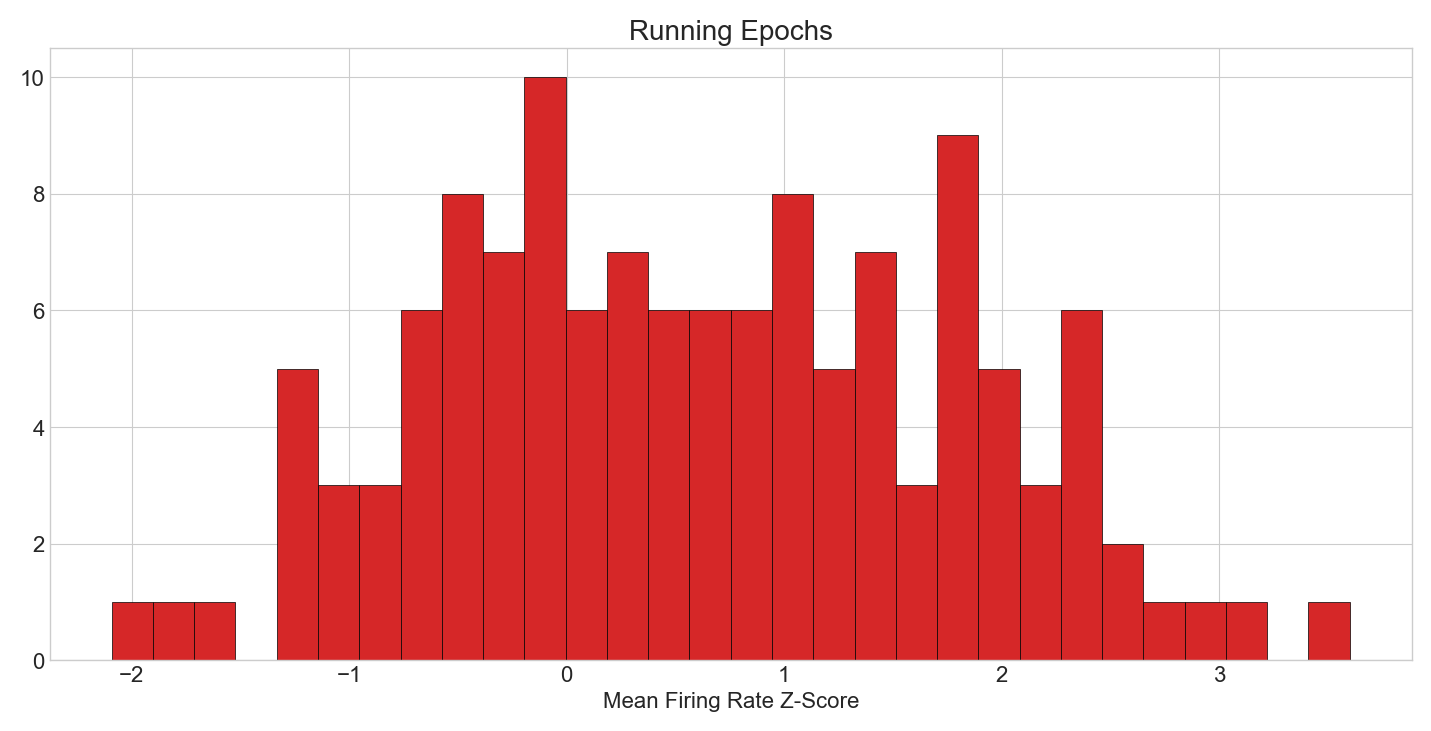

In [36]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.hist(running_Zs, bins=30, color='#d62728', edgecolor='black', linewidth=0.5)
plt.title('Running Epochs') 
plt.xlabel('Mean Firing Rate Z-Score') 

Text(0.5, 0, 'Mean Firing Rate Z-Score')

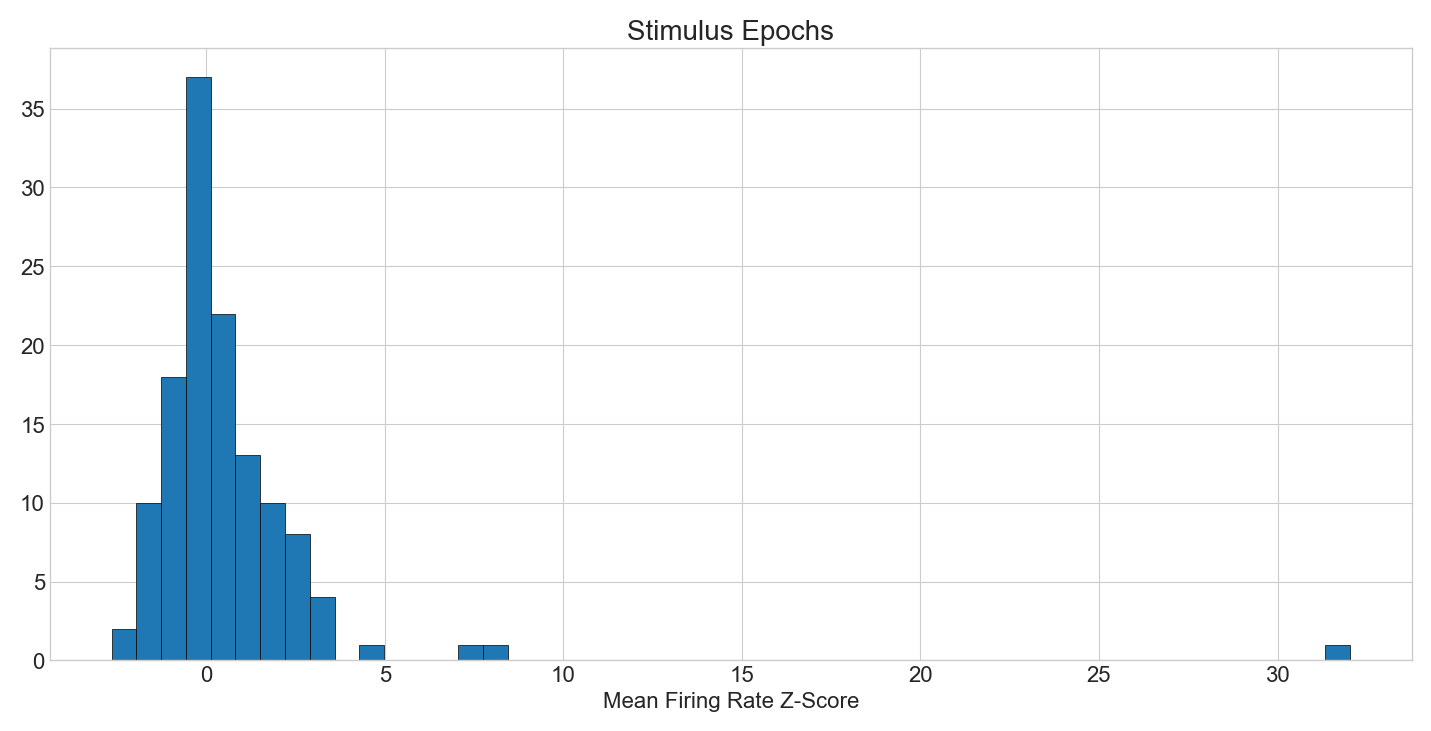

In [37]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.hist(stim_Zs, bins=50, color='#1f77b4', edgecolor='black', linewidth=0.5)
plt.title('Stimulus Epochs') 
plt.xlabel('Mean Firing Rate Z-Score') 

(-4.0, 4.0)

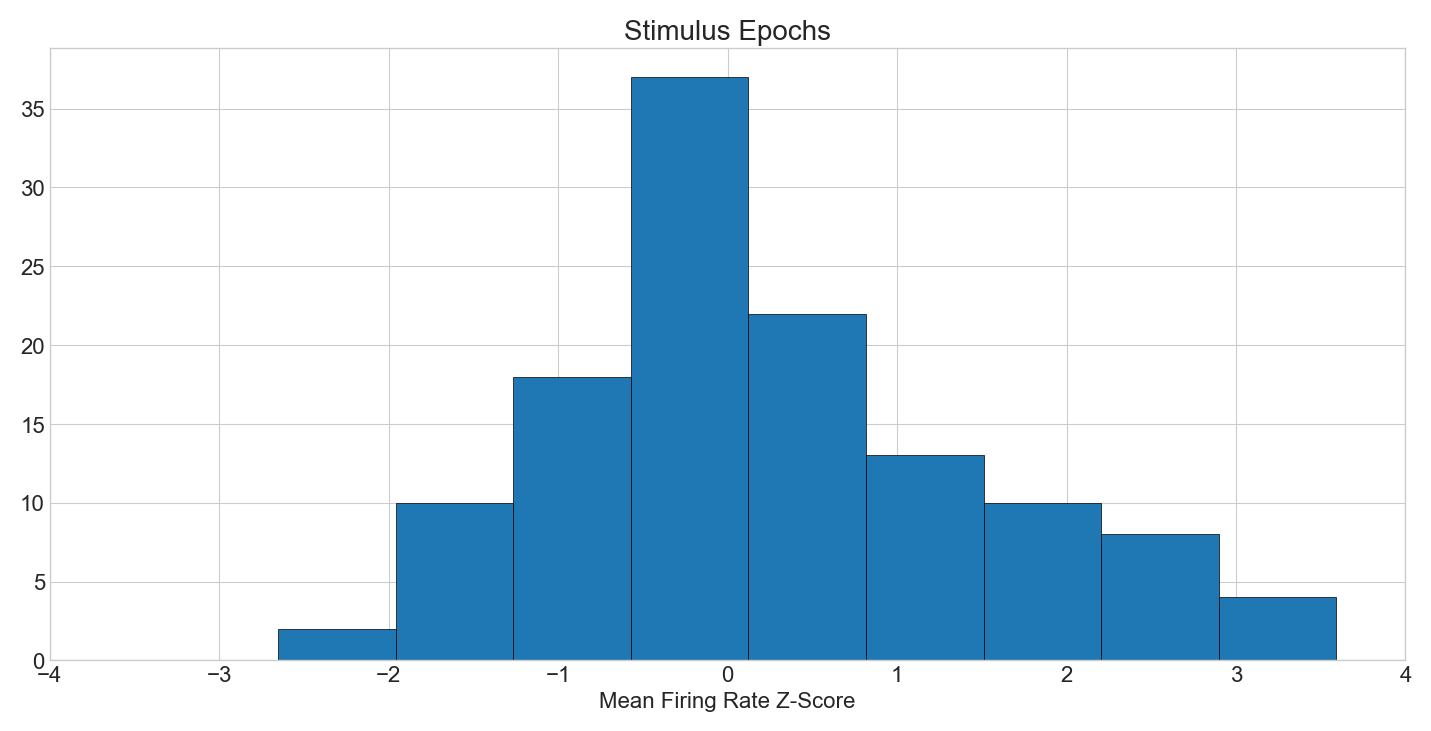

In [38]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.hist(stim_Zs, bins=50, color='#1f77b4', edgecolor='black', linewidth=0.5)
plt.title('Stimulus Epochs') 
plt.xlabel('Mean Firing Rate Z-Score') 
plt.xlim([-4, 4])

In [ ]:
# NOTES: Only stationary movies from movie and shuffled are kept, if no stationary epochs exist for a session,
# the session is thrown out, if no running epochs, then all spont units are thrown out

### Compute Spike Stats

In [ ]:
# HERE: RUN code/compute_spike_stats.py for each condition

### Plot Metric Comparisons

In [28]:
# load spike stats from spontaneous block
df_running = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/region_metrics/spontaneous_running_filtered.csv').assign(state='running').assign(block='behavior')
df_stationary = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/region_metrics/spontaneous_stationary_filtered.csv').assign(state='stationary').assign(block='behavior')

# load spike stats from movie blocks
df_movie = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/region_metrics/natural_movie_one_more_repeats_filtered.csv').assign(state='movie').assign(block='presentation')
df_shuffled = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/region_metrics/natural_movie_one_shuffled_filtered.csv').assign(state='shuffled').assign(block='presentation')

# join
metric_df = pd.concat([df_running, df_stationary, df_movie, df_shuffled], ignore_index=True).drop(columns=['running'])

In [29]:
metric_df

,session,brain_structure,epoch_idx,epoch_times,mean_firing_rate,coefficient_of_variation,spike_distance,spike_synchrony,state,block
0,847657808,VISp,0,"[5512.0, 5542.0]",0.045506,1.258770,0.224815,0.350301,running,behavior
1,847657808,VISp,1,"[6015.08, 6045.08]",0.042711,1.033246,0.236490,0.359928,running,behavior
2,840012044,VISp,0,"[4419.1, 4449.1]",0.050278,1.036429,0.186149,0.370943,running,behavior
3,840012044,VISp,1,"[5476.84, 5506.84]",0.044253,1.063250,0.195581,0.369776,running,behavior
4,839068429,VISp,0,"[4391.54, 4421.54]",0.034584,1.130199,0.150260,0.380905,running,behavior
...,...,...,...,...,...,...,...,...,...,...
2446,766640955,LGd,13,"[7281.377594154052, 7311.38]",0.050710,1.113301,0.161662,0.321154,shuffled,presentation
2447,766640955,VISp,14,"[7311.400000000001, 7341.402674154052]",0.032935,1.481575,0.199694,0.329995,shuffled,presentation
2448,766640955,LGd,14,"[7311.400000000001, 7341.402674154052]",0.054155,1.118788,0.167912,0.320403,shuffled,presentation
2449,766640955,VISp,15,"[7341.42, 7371.427734154053]",0.035315,1.362443,0.195739,0.334070,shuffled,presentation


In [30]:
metric_df.isna().sum()

session                     0
brain_structure             0
epoch_idx                   0
epoch_times                 0
mean_firing_rate            0
coefficient_of_variation    1
spike_distance              0
spike_synchrony             0
state                       0
block                       0
dtype: int64

In [31]:
metric_df[metric_df['coefficient_of_variation'].isna()]['state'].value_counts()

state
running    1
Name: count, dtype: int64

In [32]:
metric_df[metric_df['state'] == 'stationary']

,session,brain_structure,epoch_idx,epoch_times,mean_firing_rate,coefficient_of_variation,spike_distance,spike_synchrony,state,block
409,847657808,VISp,0,"[4427.179999999999, 4457.179999999999]",0.053469,1.085097,0.177721,0.365149,stationary,behavior
410,847657808,VISp,1,"[4457.179999999999, 4487.179999999999]",0.042127,1.548722,0.151729,0.359369,stationary,behavior
411,847657808,VISp,2,"[4487.179999999999, 4517.179999999999]",0.046111,1.200819,0.160167,0.363890,stationary,behavior
412,847657808,VISp,3,"[4517.179999999999, 4547.179999999999]",0.039954,1.361896,0.153681,0.365492,stationary,behavior
413,847657808,VISp,4,"[4547.179999999999, 4577.179999999999]",0.039128,1.611662,0.151693,0.359558,stationary,behavior
...,...,...,...,...,...,...,...,...,...,...
1322,766640955,LGd,41,"[6086.98, 6116.98]",0.062175,1.041792,0.220777,0.333896,stationary,behavior
1323,766640955,VISp,42,"[6116.98, 6146.98]",0.032411,1.146476,0.153667,0.356472,stationary,behavior
1324,766640955,LGd,42,"[6116.98, 6146.98]",0.049600,1.053768,0.218607,0.330759,stationary,behavior
1325,766640955,VISp,43,"[6146.98, 6176.98]",0.032739,1.005404,0.168963,0.359975,stationary,behavior


In [39]:
# drop null values
# metric_df = metric_df.dropna()

In [33]:
# define metrics to be plotted 
metrics = ['mean_firing_rate', 'spike_distance']
conditions = ['running', 'stationary', 'movie', 'shuffled']

p_vals = None #[[0.0, 0.424], [0.0, 0.09], [0.003, 0.13], [0.185,0.459]]
colors = ['#d62728', '#ff7f0e', '#1f77b4', '#2ca02c']

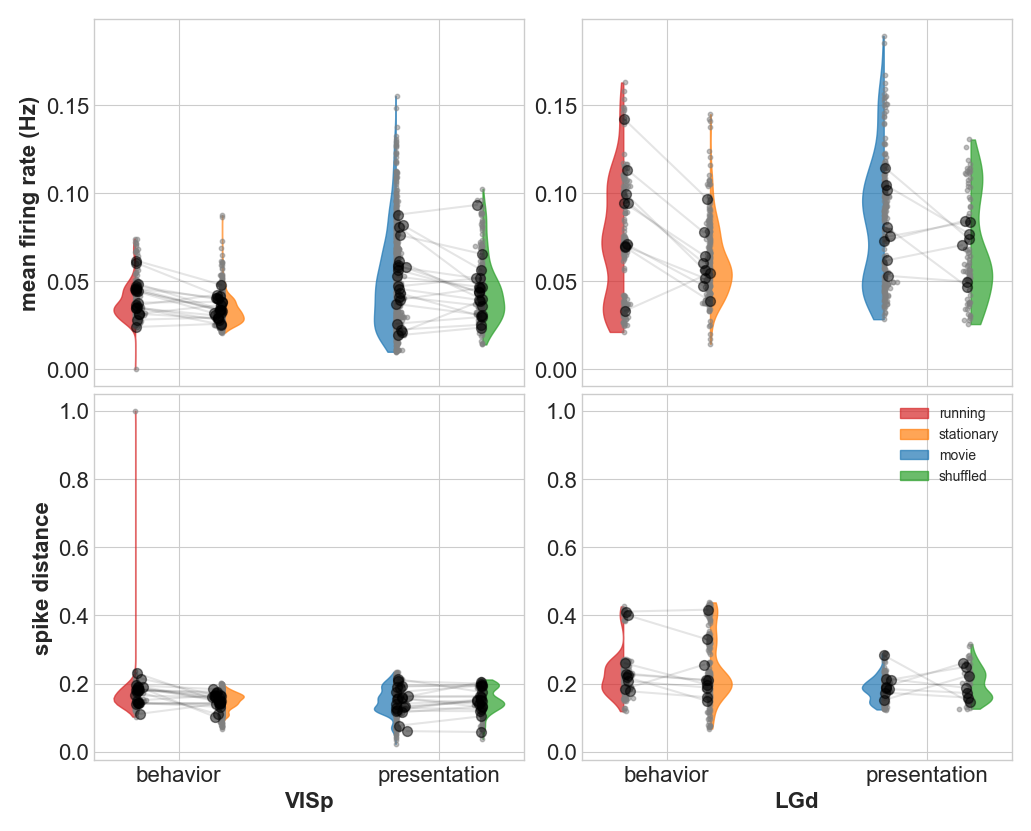

In [39]:
# plot all epochs
sync_plot(metric_df, metrics, conditions, alpha=0.7, p_vals=p_vals,
          ylabels=['mean firing rate (Hz)', 'spike distance'], colors=colors);

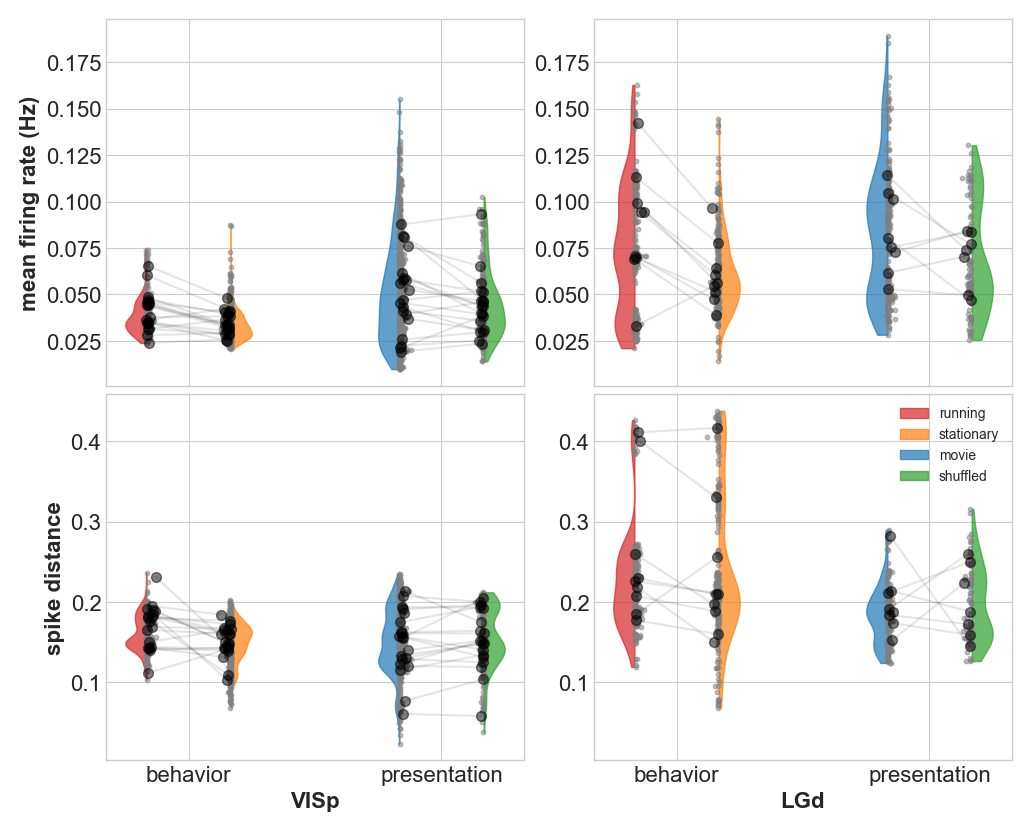

In [40]:
# IS THIS STILL NECESSARY?

# remove outliers
no_outliers_metric_df = metric_df[metric_df['spike_distance'] < 1]

# plot
sync_plot(no_outliers_metric_df, metrics, conditions, p_vals=p_vals, alpha=0.7, 
          ylabels=['mean firing rate (Hz)', 'spike distance'], colors=colors);

### Hierarchical Bootstrap

In [41]:
# Set default parameters for hierarchical bootstrap
bootstrap_params = {
    'df': None,
    'variable': None,
    'condition': 'state',
    'level_1': 'session',
    'level_2': 'epoch_idx',
    'verbose': True,
    'plot': True
}

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'mean_firing_rate' IN 'VISp' FOR 'behavior' TRIALS


p-value: 0.012
p-boot: 0.015304


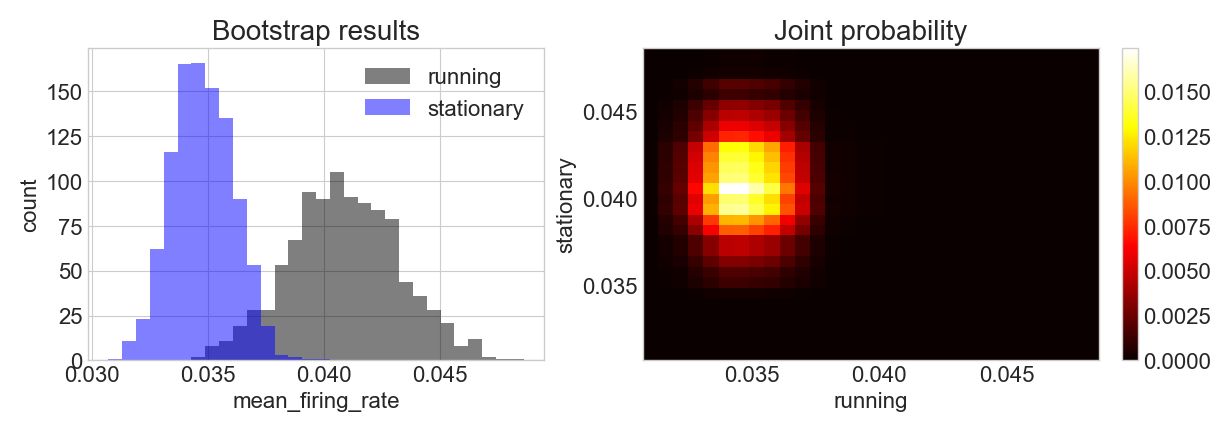

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'mean_firing_rate' IN 'VISp' FOR 'presentation' TRIALS


p-value: 0.143
p-boot: 0.15931900000000002


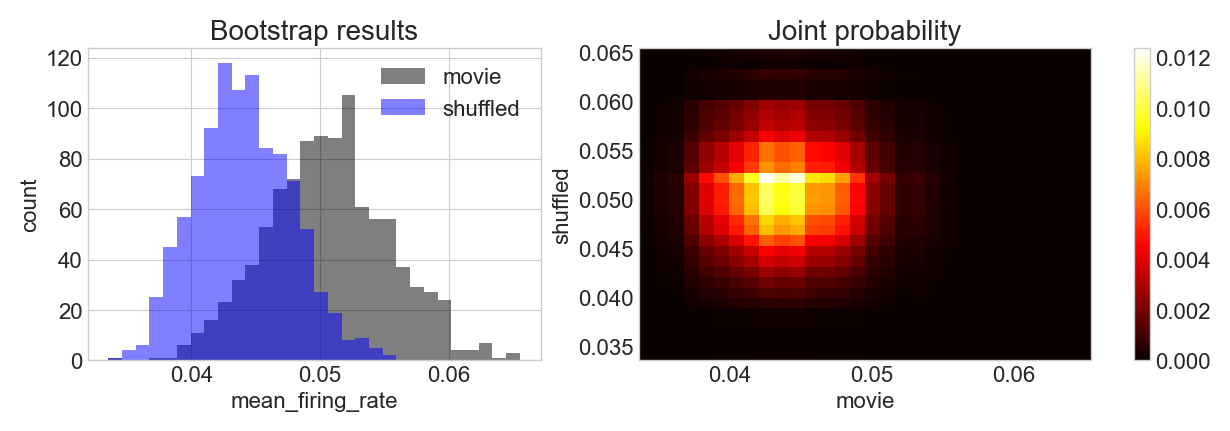

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'mean_firing_rate' IN 'LGd' FOR 'behavior' TRIALS


p-value: 0.008
p-boot: 0.011585999999999999


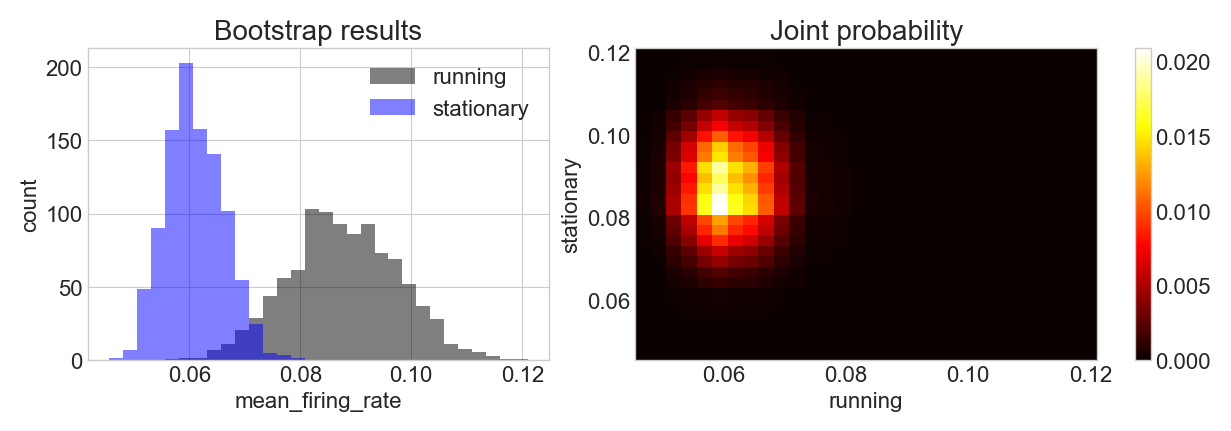

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'mean_firing_rate' IN 'LGd' FOR 'presentation' TRIALS


p-value: 0.086
p-boot: 0.10264899999999999


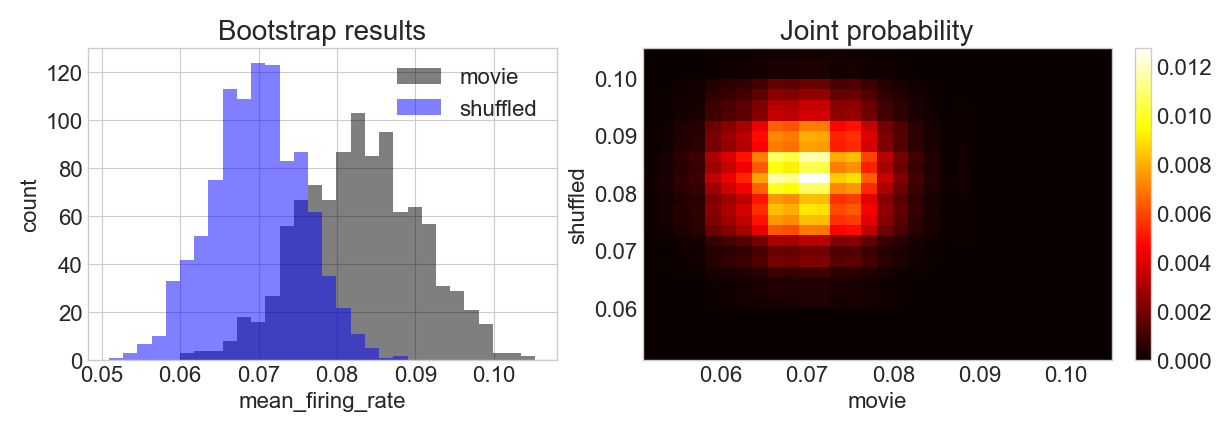

In [42]:
# offset analysis
variable = 'mean_firing_rate'
bootstrap_params['variable'] = variable
for region in metric_df['brain_structure'].unique():
    for block in metric_df['block'].unique():
        print(f'COMPUTING HIERARCHICAL BOOTSTRAP FOR \'{variable}\' IN \'{region}\' FOR \'{block}\' TRIALS\n\n')
        
        bootstrap_params['df'] = metric_df[(metric_df['brain_structure']==region)&(metric_df['block']==block)]
        
        run_hierarchical_bootstrap(**bootstrap_params)

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'spike_distance' IN 'VISp' FOR 'behavior' TRIALS


p-value: 0.003
p-boot: 0.006985000000000001


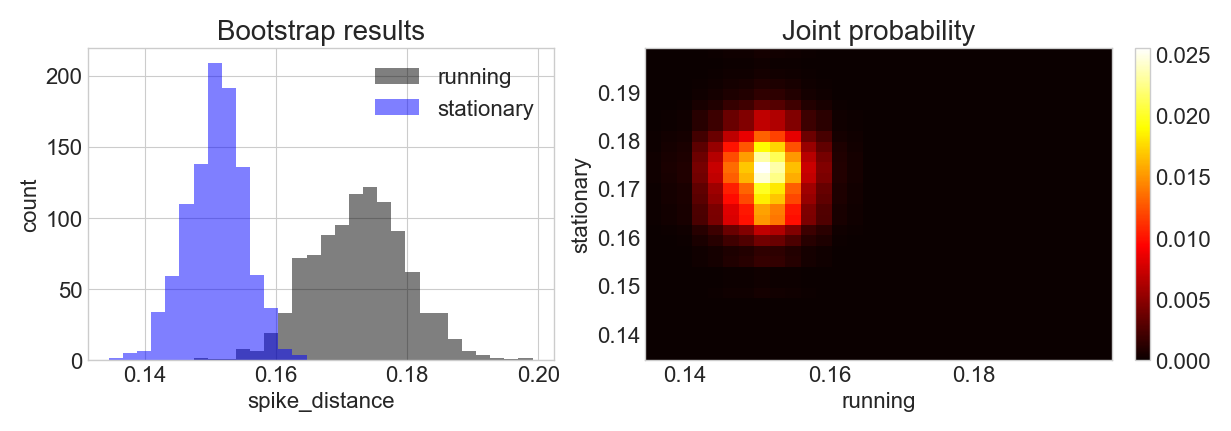

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'spike_distance' IN 'VISp' FOR 'presentation' TRIALS


p-value: 0.411
p-boot: 0.6282730000000001


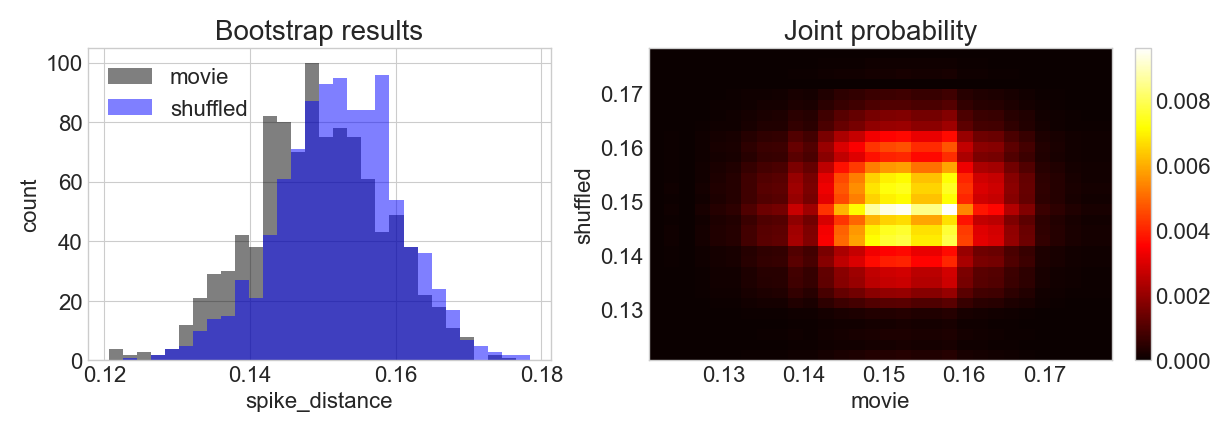

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'spike_distance' IN 'LGd' FOR 'behavior' TRIALS


p-value: 0.297
p-boot: 0.331809


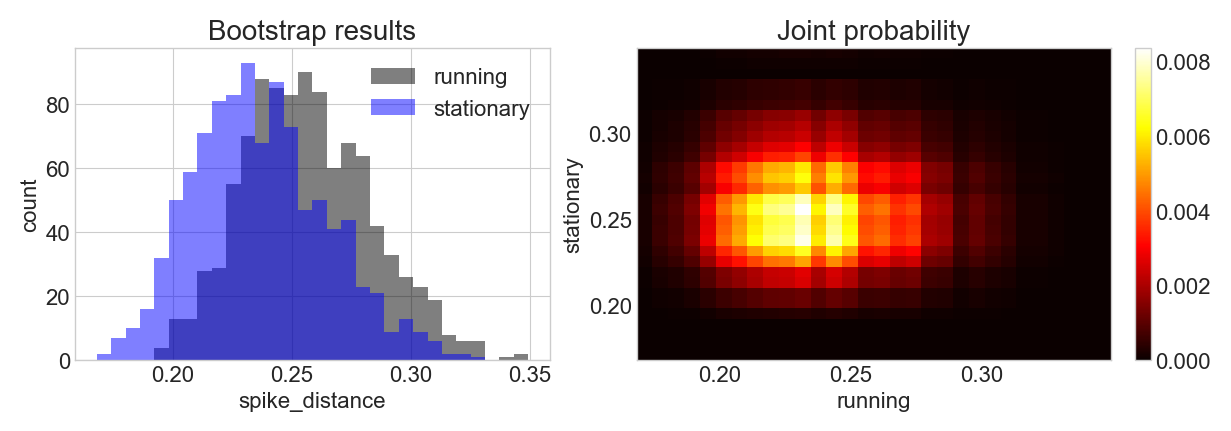

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'spike_distance' IN 'LGd' FOR 'presentation' TRIALS


p-value: 0.482
p-boot: 0.52363


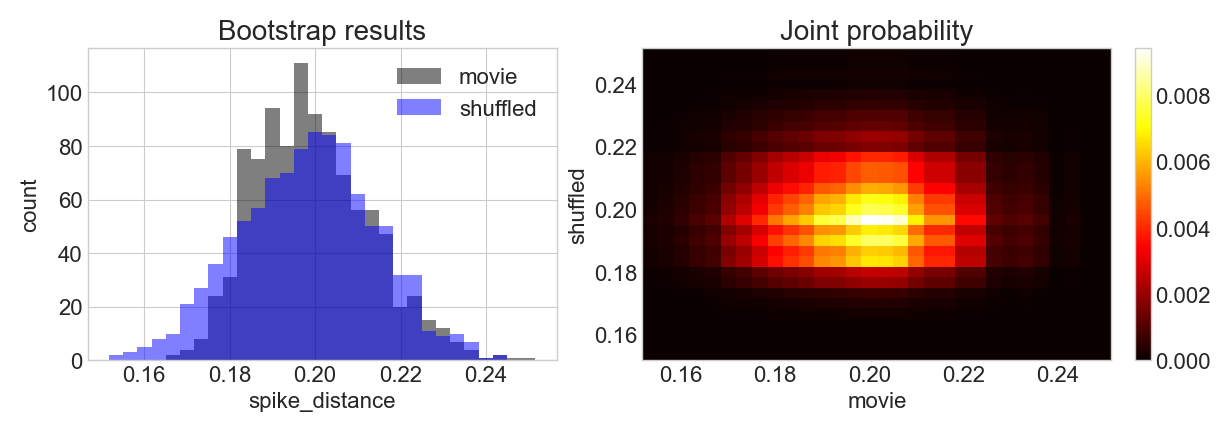

In [43]:
# spike-distance analysis
variable = 'spike_distance'
bootstrap_params['variable'] = variable
for region in metric_df['brain_structure'].unique():
    for block in metric_df['block'].unique():
        print(f'COMPUTING HIERARCHICAL BOOTSTRAP FOR \'{variable}\' IN \'{region}\' FOR \'{block}\' TRIALS\n\n')
        
        bootstrap_params['df'] = metric_df[(metric_df['brain_structure']==region)&(metric_df['block']==block)]
        
        run_hierarchical_bootstrap(**bootstrap_params)